COGS 4290 RSA

David Halpern 4/4/23

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns

In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [3]:
save_path = '/scratch/djh/rsa_class/'
raw_WORD_rsa_df = pd.read_csv(save_path + 'raw_WORD_rsa_df.csv')
raw_REC_WORD_rsa_df = pd.read_csv(save_path + 'raw_REC_WORD_rsa_df.csv')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,26,47,52) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,26,50,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Across-list category similarity

We'll start by looking at a classic result from [Haxby et al. (2001)](https://www.science.org/doi/10.1126/science.1063736). They presented subjects with images from eight different categories:

<center>
    <img src="figs/HaxbyEtal01_fig2.png" width=400>
</center>

They then compared the neural representations, finding that the patterns in "object-selective cortex" were more similar when looking at two images from the same category than across categories!

<center>
    <img src="figs/HaxbyEtal01_fig4.png" width=400>
</center>

[Kriegeskorte et. al. (2008)](https://www.sciencedirect.com/science/article/pii/S0896627308009434) conducted a similar study using fMRI in humans and neural recordings in monkeys, showing that the categorical representation of images in Inferior Temporal (IT) cortex was similar in both:

<center>
    <img src="figs/KrieEtal08_fig1.png" width=800>
</center>

Side note: you can actually analyze the original data from this study as it's freely available along with the [pyMVPA package](http://www.pymvpa.org/) (see [here](http://www.pymvpa.org/tutorial_classifiers.html) for an example showing you how to analyze this data). pyMVPA was one of the original python packages, developed by people from Jim Haxby's and Ken Norman's labs, for performing modern cognitive neuroscience analyses. The Haxby data is also available as part of [nilearn](https://nilearn.github.io/stable/decoding/decoding_intro.html?highlight=haxby), another python package for processing fMRI data.

pyMVPA was to some extent superseded by [Brainiak](brainiak.org), developed by many labs at Princeton (including Ken Norman's). Brainiak has its own RSA tutorial [here](https://brainiak.org/tutorials/06-rsa/), using data from the Kriegeskorte study. In addition, Brainiak and nilearn both have a number of other tutorials which are worth looking at if you're interested in modern fMRI methods (some of which have yet to be applied to EEG!).

That being said, if you look at these tutorials, you'll see that there's nothing fancy you need to do basic RSA with a correlation metric, just the simple correlation matrix computations from numpy or xarray, so no need to install those packages aside from them being an easy way to access these older datasets! 

Because this class is focused on EEG, rather than getting into the details of fMRI, we'll try to look for similar effects in one of our intracranial EEG datasets. We have a collected data from a number of patients doing a categorized free recall task (first reported [here](https://psycnet.apa.org/record/2018-66881-001), although we have a lot more data collected now!). This task is the same as a standard verbal free recall task except that the words on each list come a smaller number of categories. In this particular version, it also has a special structure, where each list has three categories and the items were presented in pairs of same-category words. The structure looks like this:

<center>
    <img src="figs/WeidEtal19_fig1_catFR.png" width=400>
</center>

Within a session, subjects collected early on would see at most 300 words, 12 words from each of 25 categories. After collecting data from about 120 subjects, we decided to cut the sessions in half but added another category so subjects saw 312 words from 26 categories across two "half sessions." Because the words on the lists come from a small set of categories, we can try to do a similar analysis on these data as they did in the fMRI papers mentioned above, investigating whether the representations of pairs of same category words are more similar than pairs from different categories. In most RSA analyses (like above) the focus is on regions of the brain that are known to respond to the type of stimuli in question. In intracranial EEG though, we don't get to choose where in the brain we are recording from and it's not consistent across patients. Therefore, in the analyses here, to simplify things for this class, we will just use all of the electrodes we get for each patient and look at their similarity. Perhaps surprisingly, as we'll see, this seems to work ok! 

In a related but slightly more complex analysis, [Kragel et al. (2021)](https://www.nature.com/articles/s41467-021-24393-1) showed that it was possible to decode the category of a word in this task from just electrodes within two specific brain regions (Posterior Medial, PM, and Anterior Temporal, AT):

<center>
    <img src="figs/KragEtal21_fig2c.png" width=400>
</center>

In addition, using data from an uncategorized free recall task, [Manning et al. (2012)](https://www.jneurosci.org/content/32/26/8871.short) showed that similarity of neural activity seemed to be related to a measure of semantic similarity for some subjects:

<center>
    <img src="figs/MannEtal12_fig3.png" width=400>
</center>

## Analysis

In the last notebook, we computed the similarity of the neural representation across each pair of word presentations for each subject in each session. We now need to analyze it! One tricky thing about doing this analysis as we'll learn later is that the EEG signal is really influenced by time, i.e. things that happen nearby also have similar patterns of activity. In the Haxby study, they handled this by only comparing representations across runs. Similarly, in this first analysis, we will only look at across list comparisons.

In [4]:
across_list_WORD_rsa_df = raw_WORD_rsa_df.query('(list_WORD2 > list_WORD)') 
within_list_WORD_rsa_df = raw_WORD_rsa_df.query('((list_WORD2 == list_WORD) and (serialpos_WORD2 > serialpos_WORD))')

Check out what information is contained in this dataframe. `corr_z` is the [Fisher](https://academic.oup.com/biomet/article/10/4/507/203628) [$z$-transformed](https://en.wikipedia.org/wiki/Fisher_transformation) correlation between two encoding periods. We transform it because if we average together a bunch of correlations our result will be biased relative to the true average correlation. The transformation to some extent corrects for this bias. 
Beyond that, the information contained in the `_WORD` columns refers to the word in the pair that occurred earlier in the session (on a prior list), `_WORD2` is the later word.

In [5]:
across_list_WORD_rsa_df

,category_WORD,category_num_WORD,eegfile_WORD,eegoffset_WORD,exp_version_WORD,experiment_WORD,intrusion_WORD,is_stim_WORD,item_name_WORD,item_num_WORD,...,phase_WORD,recog_resp_WORD,recog_rt_WORD,recognized_WORD,rejected_WORD,phase_WORD2,recog_resp_WORD2,recog_rt_WORD2,recognized_WORD2,rejected_WORD2
11,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,officesupplies,17,/protocols/r1/subjects/R1045E/experiments/catF...,491162,1.05,catFR1,-999,0,PAPER,207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3273835,bodyparts,3,/protocols/r1/subjects/R1541T/experiments/catF...,1153986,NaN,catFR1,-999,0,ARM,40,...,NON-STIM,-999.0,-999.0,-999.0,-999.0,NON-STIM,-999.0,-999.0,-999.0,-999.0
3273836,bodyparts,3,/protocols/r1/subjects/R1541T/experiments/catF...,1153986,NaN,catFR1,-999,0,ARM,40,...,NON-STIM,-999.0,-999.0,-999.0,-999.0,NON-STIM,-999.0,-999.0,-999.0,-999.0
3273837,bodyparts,3,/protocols/r1/subjects/R1541T/experiments/catF...,1153986,NaN,catFR1,-999,0,ARM,40,...,NON-STIM,-999.0,-999.0,-999.0,-999.0,NON-STIM,-999.0,-999.0,-999.0,-999.0
3273838,bodyparts,3,/protocols/r1/subjects/R1541T/experiments/catF...,1153986,NaN,catFR1,-999,0,ARM,40,...,NON-STIM,-999.0,-999.0,-999.0,-999.0,NON-STIM,-999.0,-999.0,-999.0,-999.0


In order to start looking at this we need to start averaging. We want to be careful about how we do this because the data isn't independent. There's a lot of structure since each word occurred on a list on a session for a subject. We'll first look only at comparisons between the same category on a specific pair of lists in a session and get the average representation there. 

In [6]:
across_list_WORD_rsa_list_df = across_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'list_WORD2', 'category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z': 'mean'})

If you haven't seen this code pattern yet, it's super useful and comes up all the time in data science. It's called a [split-apply-combine pattern](https://www.jstatsoft.org/article/view/v040i01) because we split up the data into chunks, run some code on each of them (here taking the mean correlation), and then recombine them again. You can see more about how this works in `pandas` [here](https://pandas.pydata.org/docs/user_guide/groupby.html). We then continue taking the average within session, and subject until we finally get to the average similarity between items from a pair of categories in our dataset.

In [7]:
across_list_WORD_rsa_session_df = across_list_WORD_rsa_list_df.groupby(
    ['subject_WORD', 'session_WORD', 'category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z': 'mean'})
across_list_WORD_rsa_subject_df = across_list_WORD_rsa_session_df.groupby(
    ['subject_WORD', 'category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z': 'mean'})
across_list_WORD_rsa_category_df = across_list_WORD_rsa_session_df.groupby(
    ['category_WORD', 'category_WORD2'], as_index=False
).agg({'corr_z': 'mean'})

As we mentioned before, some subjects saw 26 categories while some only saw 25. To make this analysis more straightforward, we'll remove the 26th category, "fabrics" from the analysis.

In [8]:
across_list_WORD_rsa_category_df = across_list_WORD_rsa_category_df.query('(category_WORD != "fabric") and ' + 
                                                                            '(category_WORD2 != "fabric")')

Finally we'll reshape this data into a matrix so we can plot it like the Haxby/Kriegeskorte analyses above. Note that this matrix isn't symmetric -- the y-axis corresponds to the earlier word and the x-axis to the later word.

In [9]:
across_list_WORD_rsa_category_mat = across_list_WORD_rsa_category_df.pivot_table(
    index=['category_WORD'], columns=['category_WORD2'], 
    values='corr_z')

[Text(0.5, 15.0, 'Later item'), Text(33.0, 0.5, 'Earlier item')]

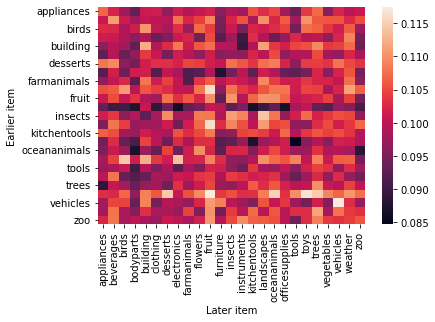

In [10]:
g = sns.heatmap(across_list_WORD_rsa_category_mat)
g.set(xlabel='Later Item', ylabel='Earlier Item')

This doesn't look like much -- the diagonal structure isn't super apparent. One reason is that there is a lot of uncontrolled variance here. Some subjects' neural activity is more category driven than others so the average similarities vary a lot by subject. It also varies by session and list. Use the split apply combine approach to see what the variability in average similarity looks like across subjects. Use seaborn [displot](https://seaborn.pydata.org/generated/seaborn.displot.html) to investigate

What we are really interested in is, within a subject and a pair of lists, do same category words look more similar than across category? Therefore we'll subtract the average similarity within a pair of lists from the `corr_z` column. This gives us only the within-list-pair variance. This is often a [good strategy](https://www.tqmp.org/RegularArticles/vol01-1/p042/p042.pdf) for visualizing effects in studies like this where there is hierarchical structure in the design (subjects/sessions/lists). We'll store this in the `corr_z_list_adj` column

In [18]:
across_list_WORD_rsa_df['corr_z_list_mean'] = across_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'list_WORD2'])['corr_z'].transform('mean')
across_list_WORD_rsa_df['corr_z_list_adj'] = (across_list_WORD_rsa_df['corr_z'] - 
                                                     across_list_WORD_rsa_df['corr_z_list_mean'])
within_list_WORD_rsa_df['corr_z_list_mean'] = within_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD'])['corr_z'].transform('mean')
within_list_WORD_rsa_df['corr_z_list_adj'] = (within_list_WORD_rsa_df['corr_z'] - 
                                                     within_list_WORD_rsa_df['corr_z_list_mean'])

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [13]:
across_list_WORD_rsa_df['same_category'] = across_list_WORD_rsa_df['category_WORD'] == across_list_WORD_rsa_df['category_WORD2']
across_list_WORD_rsa_df['same_category_list'] = across_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'list_WORD2']
)['same_category'].transform('nunique')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
across_list_WORD_rsa_category_df = across_list_WORD_rsa_category_df.query(
    '(category_WORD != "fabric") and ' + 
    '(category_WORD2 != "fabric")')
across_list_WORD_rsa_category_mat = across_list_WORD_rsa_category_df.pivot_table(
    index=['category_WORD'], columns=['category_WORD2'], 
    values='corr_z_list_adj')

In [1]:
g = sns.heatmap(across_list_WORD_rsa_category_mat)
g.set(xlabel='Later Item', ylabel='Earlier Item')

NameError: name 'sns' is not defined

This still doesn't look amazing, you can't really see a diagonal unless you really squint. It's challenging to see effects like this at some level because of the range of electrodes you get across patients. However, we can focus our analysis a little more. Let's see if same category comparisons are more similar than across in general.

In [17]:
across_list_WORD_rsa_df['same_category'] = across_list_WORD_rsa_df['category_WORD'] == across_list_WORD_rsa_df['category_WORD2']
across_list_WORD_rsa_list_df = across_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'list_WORD2', 'same_category'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
across_list_WORD_rsa_session_df = across_list_WORD_rsa_list_df.groupby(
    ['subject_WORD', 'session_WORD', 'same_category'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
across_list_WORD_rsa_subject_df = across_list_WORD_rsa_session_df.groupby(
    ['subject_WORD', 'same_category'], as_index=False
).agg({'corr_z_list_adj': 'mean'})

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


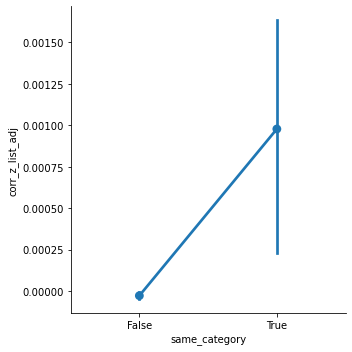

In [18]:
sns.catplot(x='same_category', y='corr_z_list_adj', 
            data=across_list_WORD_rsa_subject_df, kind='point')

In [ ]:
g = sns.catplot(x='same_category', y='corr_z_list_adj', 
            data=across_list_WORD_rsa_subject_df, kind='point')
g.set(xlabel='Same Category', ylabel='List-centered $z$-transformed Correlation')

Now we can see that there is in fact a difference, although it is somewhat small. In contrast, we would not have been able to see this without subtracting out the list mean.

In [19]:
across_list_WORD_rsa_df['same_category'] = across_list_WORD_rsa_df['category_WORD'] == across_list_WORD_rsa_df['category_WORD2']
across_list_WORD_rsa_list_df = across_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'list_WORD2', 'same_category'], as_index=False
).agg({'corr_z': 'mean'})
across_list_WORD_rsa_session_df = across_list_WORD_rsa_list_df.groupby(
    ['subject_WORD', 'session_WORD', 'same_category'], as_index=False
).agg({'corr_z': 'mean'})
across_list_WORD_rsa_subject_df = across_list_WORD_rsa_session_df.groupby(
    ['subject_WORD', 'same_category'], as_index=False
).agg({'corr_z': 'mean'})

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


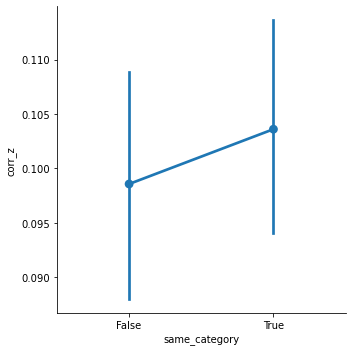

In [20]:
sns.catplot(x='same_category', y='corr_z', data=across_list_WORD_rsa_subject_df, kind='point')

In [ ]:
g = sns.catplot(x='same_category', y='corr_z', 
            data=across_list_WORD_rsa_subject_df, kind='point')
g.set(xlabel='Same Category', ylabel='$z$-transformed Correlation')

# Serial position similarity

The next set of results we'll investigate are from [Manning et al. (2011)](https://www.pnas.org/doi/10.1073/pnas.1015174108). The first result that Manning showed was that neural activity seemed to drift such that the similarity of patterns of intracranial EEG decreased as a function of distance in the list.

<center>
    <img src="figs/MannEtal11A.png" width=400>
</center>

We'll again do this analysis within list.

In [19]:
within_list_WORD_rsa_list_df = within_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'serialpos_WORD', 'serialpos_WORD2'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
within_list_WORD_rsa_session_df = within_list_WORD_rsa_list_df.groupby(
    ['subject_WORD', 'session_WORD', 'serialpos_WORD', 'serialpos_WORD2'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
within_list_WORD_rsa_subject_df = within_list_WORD_rsa_session_df.groupby(
    ['subject_WORD', 'serialpos_WORD', 'serialpos_WORD2'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
within_list_WORD_rsa_serialpos_df = within_list_WORD_rsa_session_df.groupby(
    ['serialpos_WORD', 'serialpos_WORD2'], as_index=False
).agg({'corr_z_list_adj': 'mean'})

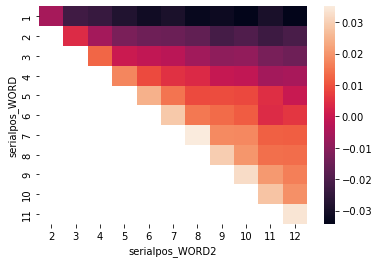

In [23]:
g = sns.heatmap(within_list_WORD_rsa_serialpos_mat)

In [21]:
within_list_WORD_rsa_serialpos_mat = within_list_WORD_rsa_serialpos_df.pivot_table(
    index=['serialpos_WORD'], columns=['serialpos_WORD2'], 
    values='corr_z_list_adj')

[Text(0.5, 15.0, 'Later Item'), Text(33.0, 0.5, 'Earlier Item')]

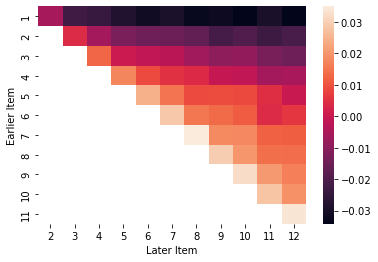

In [22]:
g = sns.heatmap(within_list_WORD_rsa_serialpos_mat)
g.set(xlabel='Later Item', ylabel='Earlier Item')

From this heatmap, we can clearly see how the similarity increases as a function of distance. We can replot this data as a function of distance to look a bit more like the Manning et al. plot

In [25]:
within_list_WORD_rsa_df['serialpos_dist'] = within_list_WORD_rsa_df['serialpos_WORD2'] - within_list_WORD_rsa_df['serialpos_WORD']
within_list_WORD_rsa_list_df = within_list_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'serialpos_dist'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
within_list_WORD_rsa_session_df = within_list_WORD_rsa_list_df.groupby(
    ['subject_WORD', 'session_WORD', 'serialpos_dist'], as_index=False
).agg({'corr_z_list_adj': 'mean'})
within_list_WORD_rsa_subject_df = within_list_WORD_rsa_session_df.groupby(
    ['subject_WORD', 'serialpos_dist'], as_index=False
).agg({'corr_z_list_adj': 'mean'})

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
sns.catplot(x='serialpos_dist', y='corr_z_list_adj', 
            data=within_list_WORD_rsa_subject_df, kind='point')
g.set(xlabel='Study distance', ylabel='List-transformed $z$-transformed Correlation')

We'll also show that being from the same category influences similarity on top of the serial position distance within a list. It's crucial to account for both at the same time because of the category structure of the list. Use the split-apply-combine technique with both `serialpos_dist` and `same_category` to get the mean within each possible combination. Use the [catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html) parameter `hue` to display both variables on the same plot.

# Encoding-Retrieval RSA analysis

Now we'll look at the key analysis in Manning et al. (2011). They showed that right before you retrieve an item, the neural activity that displayed the drift above looks more similar to the item youre about to retrieve than any other item. On top of that, it is also more similar to serial positions that were near by at encoding. This suggests that you not only retrieve an item but it's general *context*. This is a key prediction of retrieved context theories of free recall.

<center>
    <img src="figs/MannEtal11_fig1.png" width=600>
</center>

<center>
    <img src="figs/MannEtal11B.png" width=400>
</center>

We'll only look at comparisons within a list and on retrievals where a word that was actually on the list was retrieved

In [14]:
within_list_correct_REC_WORD_rsa_df = raw_REC_WORD_rsa_df.query(
    'list_REC_WORD == list_WORD and serialpos_REC_WORD != -999')

Take a look at the `within_list_correct_REC_WORD_rsa_df` and make sure you understand the information that is contained in that dataframe

How would you compute the serialpos_lag used in the above plot?

Like above, we'll subtract out variance we are not interested in. Here, we will compute relative similarity within each retrieval. We can use the `outpos` column to do that since it indicates each retrieval.

In [15]:
within_list_correct_REC_WORD_rsa_df['corr_z_outpos_mean'] = within_list_correct_REC_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'outpos_REC_WORD'])['corr_z'].transform('mean')
within_list_correct_REC_WORD_rsa_df['corr_z_outpos_adj'] = (within_list_correct_REC_WORD_rsa_df['corr_z'] - 
                                                     within_list_correct_REC_WORD_rsa_df['corr_z_outpos_mean'])

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Using that, we get a figure that looks a lot like the one from Manning et al.!

In [32]:
within_list_REC_WORD_rsa_list_df = within_list_correct_REC_WORD_rsa_df.groupby(
    ['subject_WORD', 'session_WORD', 'list_WORD', 'serialpos_lag'], as_index=False
).agg({'corr_z_outpos_adj': 'mean'})
within_list_REC_WORD_rsa_session_df = within_list_REC_WORD_rsa_list_df.groupby(
    ['subject_WORD', 'session_WORD', 'serialpos_lag'], as_index=False
).agg({'corr_z_outpos_adj': 'mean'})
within_list_REC_WORD_rsa_subject_df = within_list_REC_WORD_rsa_session_df.groupby(
    ['subject_WORD', 'serialpos_lag'], as_index=False
).agg({'corr_z_outpos_adj': 'mean'})

In [ ]:
g = sns.catplot(y='corr_z_outpos_adj', x='serialpos_lag',
            data=within_list_REC_WORD_rsa_subject_df.query(
                'serialpos_lag <= 5 and serialpos_lag >= -5'), kind='point')
g.set(xlabel='Lag', ylabel='Retrieval-centered $z$-transformed Correlation')

Manning et al. (2012) showed that items that were semantically similar were *also* more similar to the moments just prior to item retrieval. Kragel et al. (2021) also showed that you could decode the category of the item that was about to be retrieved in the moments just before retrieval.

<center>
    <img src="figs/KragEtal21_fig3b_cat.png" width=400>
</center>

 We are going to try to look at the same thing here. Just like above, make the above plot as a function of both `serialpos_lag` and `same_category`

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Exercise: category similarity during encoding

Now try to investigate any other effect you are interested in in this RSA matrix during categorized free recall. Take a look at the available columns and see what interests you. One additional possibility is to replicate [Kuhl et al. (2012)](https://www.sciencedirect.com/science/article/pii/S0028393211004088). They asked subjects to do an image-word cued recall task and investigated neural representations of the images during encoding. They showed that when two images from the same category were both recalled, their Temporal cortext representation was more similar than when they were both forgotten and the opposite when they were from different categories. 

<center>
    <img src="figs/KuhlEtal12_fig6.jpeg" width=400>
</center>

We have a lot of temporal cortex electrodes so as a first pass we can try to replicate this effect here in the encoding RSA. You might find it useful to create a `pair_recalled` variable like this. It isn't totally straightforward to replicate this due to the structure of our task so play around with it a bit!

In [37]:
within_list_WORD_rsa_df['pair_recalled'] = within_list_WORD_rsa_df['recalled_WORD'] + within_list_WORD_rsa_df['recalled_WORD2']

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
